In [1]:
#import gpytorch
from argparse import Namespace
from datetime import datetime
from hypnettorch.data.special.regression1d_data import ToyRegression
from hypnettorch.mnets import MLP
from hypnettorch.utils.sim_utils import setup_environment
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared
import sys
from time import time
import torch

# Pretend that notebook is located in base directory of this repo.
curr_dir = os.path.basename(os.path.abspath(os.curdir))
base_dir = os.path.abspath('../..')
if curr_dir == 'nngp' and base_dir != sys.path[0]:
    sys.path.insert(0, base_dir)

from data.regression_utils import generate_1d_dataset
from nngp.nngp import inference_with_isotropic_gaussian_ll, gen_inference_kernels, cholesky_adaptive_noise
from nngp import MLPKernel #, RBFNetKernel 
from utils import notebook as nutils
from utils.plotting import plot_predictive_distributions_1dr


from IPython.display import display, Markdown, Latex
#display(Markdown('*some markdown* $\phi$'))

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Create output directory and other helpers.
config = Namespace()
config.out_dir = './out/continual_learning/run_' + \
    datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
config.loglevel_info = False
config.random_seed = 42
config.use_cuda = False # CPU usually faster for simple problems.
config.deterministic_run = True
# Delete file from previous tutorial session:
if os.path.exists(config.out_dir):
    shutil.rmtree(config.out_dir)
device, writer, logger = setup_environment(config, logger_name='cl_logger')

Created output folder ./out/continual_learning/run_2021-11-14_19-26-56.
11/14/2021 07:26:56 PM - INFO - Using cuda: False


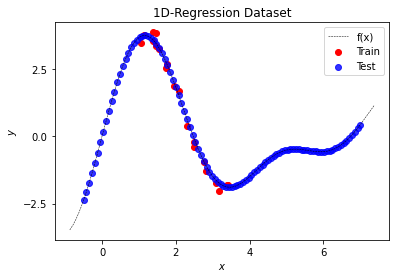

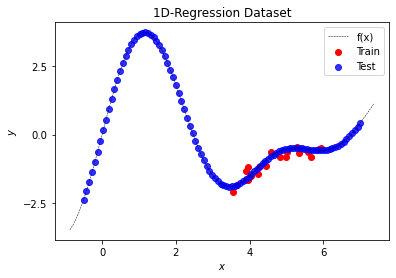

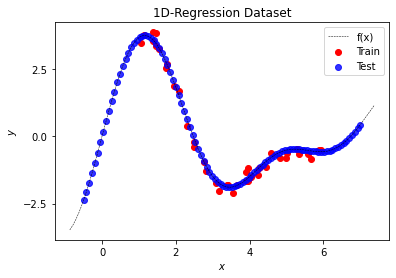

In [2]:
data_kwargs = {
    'map_function': lambda x: 2*np.sin(x)+np.sin(np.sqrt(2)*x)+np.sin(np.sqrt(3)*x),
    'num_train': 20,
    'test_inter': [-0.5, 7.0],
    'num_test': 100,
    'val_inter': None,
    'num_val': None,
    'std': .2,
    'rseed': 42,
}

data1 = ToyRegression(train_inter=[1, 3.5], **data_kwargs)
data1.plot_dataset()
data2 = ToyRegression(train_inter=[3.5, 6], **data_kwargs)
data2.plot_dataset()

X1_train_np = data1.get_train_inputs()
Y1_train_np = data1.get_train_outputs()
X2_train_np = data2.get_train_inputs()
Y2_train_np = data2.get_train_outputs()
X_all_train_np = np.concatenate([X1_train_np, X2_train_np], axis=0)
Y_all_train_np = np.concatenate([Y1_train_np, Y2_train_np], axis=0)
X_test_np = data1.get_test_inputs()

# Translate grid to PyTorch tensor.
X1_train = torch.from_numpy(X1_train_np.astype(np.float32)).to(device)
Y1_train = torch.from_numpy(Y1_train_np.astype(np.float32)).to(device)
X2_train = torch.from_numpy(X2_train_np.astype(np.float32)).to(device)
Y2_train = torch.from_numpy(Y2_train_np.astype(np.float32)).to(device)
X_all_train = torch.from_numpy(X_all_train_np.astype(np.float32)).to(device)
Y_all_train = torch.from_numpy(Y_all_train_np.astype(np.float32)).to(device)
X_test = torch.from_numpy(X_test_np.astype(np.float32)).to(device)

# Create a dataset containing the combined data for plotting
data_kwargs['num_train'] *= 2
data_all = ToyRegression(train_inter=[3.5, 6], **data_kwargs)
tinds = data_all._data['train_inds']
data_all._data['in_data'][tinds] = X_all_train_np
data_all._data['out_data'][tinds] = Y_all_train_np
data_all.plot_dataset()

assert np.all(np.equal(data1.get_test_inputs(),
                       data_all.get_test_inputs()))

likelihood_var = .2 # Ground-truth

In [3]:
pd_plot_kwargs = {
    'sigma_ll': None, #likelihood_var,
    'show_title': False,
    'xticks': [0, 3, 6],
    'yticks': [-3, 0, 3],
    'xlim': [-.5, 6.5],
    'ylim': [-4, 4],
    'show_legend': True,
    'out_dir': config.out_dir,
    'ts': 30,
    'lw': 15,
    'ms': 5,
    'figsize': (12, 7),
    'show_plot': True,
    'vlines': [3.5],
}

## Gaussian Process Regression

In [4]:
gp_priors_struct = [
    {'type': 'rbf',
     'kernel_params': {'length_scale': 1., 'length_scale_bounds': 'fixed'}},
    #{'type': 'ess',
    # 'kernel_params': {'length_scale': 1.0, 'length_scale_bounds': 'fixed',
    #                   'periodicity': 1, 'periodicity_bounds': 'fixed'}},
]

for pdict in gp_priors_struct:
    if pdict['type'] == 'rbf':
        kernel = RBF(**pdict['kernel_params'])
    elif pdict['type'] == 'ess':
        kernel = ExpSineSquared(**pdict['kernel_params'])
    pdict['kernel'] = kernel
    
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=likelihood_var, 
                                   random_state=42)
    pdict['gpr_instance'] = gpr

Type **rbf**, specs: {'length_scale': 1.0, 'length_scale_bounds': 'fixed'}

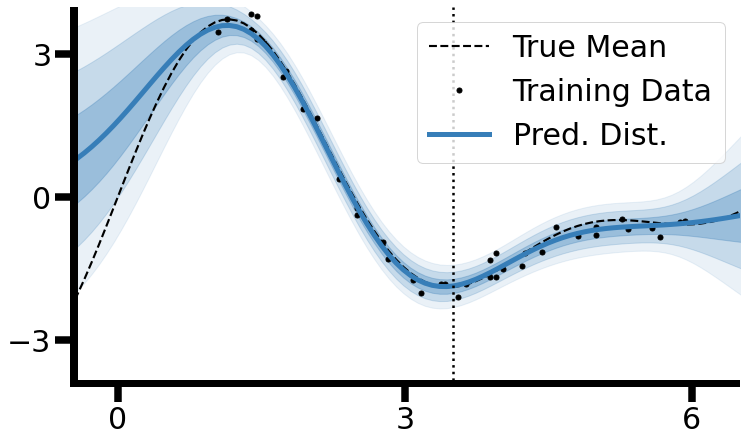

Type **rbf**, specs: {'length_scale': 1.0, 'length_scale_bounds': 'fixed'}

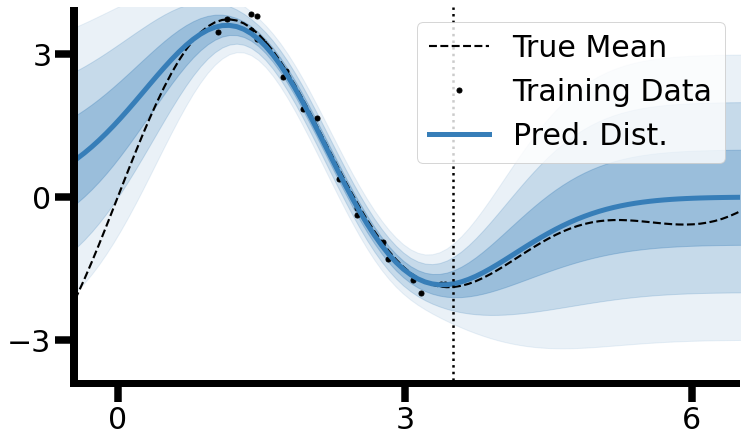

Type **rbf**, specs: {'length_scale': 1.0, 'length_scale_bounds': 'fixed'}

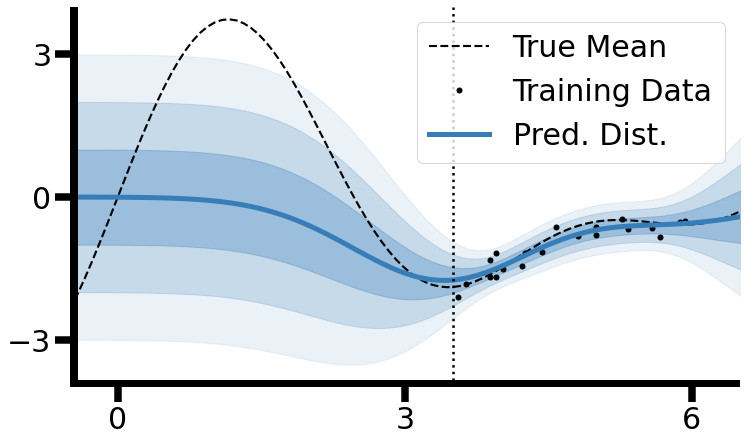

In [5]:
for (X_train_curr, Y_train_curr, data_curr, name) in \
        [(X_all_train_np, Y_all_train_np, data_all, 'all tasks'),
         (X1_train_np, Y1_train_np, data1, 'task 1'),
         (X2_train_np, Y2_train_np, data2, 'task 2')]:
    for pdict in gp_priors_struct:
        display(Markdown('Type **%s**, specs: %s' % \
                         (pdict['type'], str(pdict['kernel_params']))))

        kernel = pdict['kernel']
        gpr = pdict['gpr_instance']

        #K = kernel(X_train_np)
        gpr = GaussianProcessRegressor(kernel=kernel, alpha=likelihood_var, 
                                       random_state=42).fit(X_train_curr, Y_train_curr)

        #rbf_train_mean, rbf_train_std = gpr.predict(X_train_np, return_std=True)
        grid_mean, grid_std = gpr.predict(X_test_np, return_std=True)
        grid_samples = gpr.sample_y(X_test_np, n_samples=10).squeeze(1)

        plot_predictive_distributions_1dr(data_curr, X_test, pd_samples=None,
            pd_mean=grid_mean, pd_std=grid_std,
            title='GP posterior over functions',
            filename=None, **pd_plot_kwargs)

        #plot_predictive_distributions_1dr(data_curr, X_test, pd_samples=grid_samples,
        #    pd_mean=None, pd_std=None,
        #    title='GP posterior samples',
        #    filename=None, **pd_plot_kwargs)

## GP Regression with NNGP Kernels

In [6]:
nngp_kernel_properties = [
    ### Relu - Analytic ###
    {'name': 'ana_relu_1l', 'type': 'analytic',
     'params': {'n_layer': 1, 'nonlinearity': torch.nn.ReLU(), 'sigma2_w': 1., 'sigma2_b': 1.},
     'kernel_params': {}},
    {'name': 'ana_relu_2l', 'type': 'analytic',
     'params': {'n_layer': 2, 'nonlinearity': torch.nn.ReLU(), 'sigma2_w': 1., 'sigma2_b': 1.},
     'kernel_params': {}},
    ### Error Function - Analytic ###
    {'name': 'ana_erf_1l', 'type': 'analytic',
     'params': {'n_layer': 1, 'nonlinearity': torch.erf, 'sigma2_w': 1., 'sigma2_b': 1.},
     'kernel_params': {}},
    {'name': 'ana_erf_2l', 'type': 'analytic',
     'params': {'n_layer': 2, 'nonlinearity': torch.erf, 'sigma2_w': 1., 'sigma2_b': 1.},
     'kernel_params': {}},
    ### Cosine - Analytic ###
    {'name': 'ana_cos_1l', 'type': 'analytic',
     'params': {'n_layer': 1, 'nonlinearity': torch.cos, 'sigma2_w': 1., 'sigma2_b': 1.},
     'kernel_params': {}},
]

nngp_kernel_properties = [
    ### Cosine - Analytic ###
    {'name': 'ana_cos_1l', 'type': 'analytic',
     'params': {'n_layer': 1, 'nonlinearity': torch.cos, 'sigma2_w': 1., 'sigma2_b': 1.},
     'kernel_params': {}},
]

nngp_prpps_all = [dict(dd) for dd in nngp_kernel_properties]
nngp_prpps_task1 = [dict(dd) for dd in nngp_kernel_properties]
nngp_prpps_task2 = [dict(dd) for dd in nngp_kernel_properties]

nutils.compute_kernel_values(nngp_prpps_all, X_test, X_all_train, Y_all_train,
                             nutils.determine_mlp_kernel_func, test_bs=50,
                             out_dir=None, try_inference=False,
                             heatmap_kwargs=None)

nutils.compute_kernel_values(nngp_prpps_task1, X_test, X1_train, Y1_train,
                             nutils.determine_mlp_kernel_func, test_bs=50,
                             out_dir=None, try_inference=False,
                             heatmap_kwargs=None)

nutils.compute_kernel_values(nngp_prpps_task2, X_test, X2_train, Y2_train,
                             nutils.determine_mlp_kernel_func, test_bs=50,
                             out_dir=None, try_inference=False,
                             heatmap_kwargs=None)

Investiagting **ana_cos_1l**

  0%|          | 0/100 [00:00<?, ?it/s]

Kernel computation took 0.026933 seconds.

Investiagting **ana_cos_1l**

  0%|          | 0/100 [00:00<?, ?it/s]

Kernel computation took 0.019430 seconds.

Investiagting **ana_cos_1l**

  0%|          | 0/100 [00:00<?, ?it/s]

Kernel computation took 0.016955 seconds.

Type **ana_cos_1l**

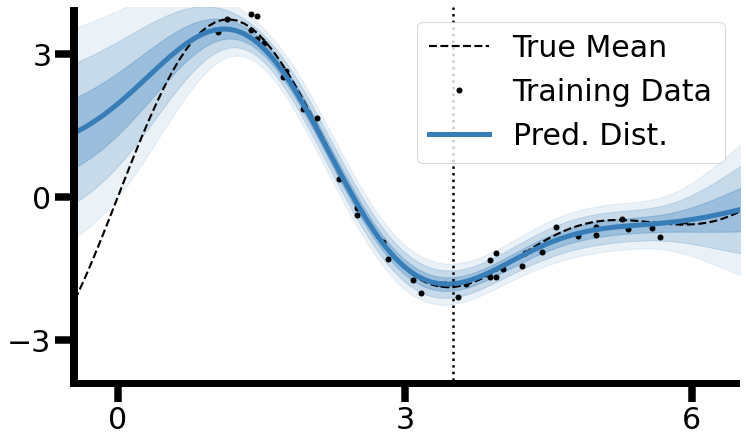

Type **ana_cos_1l**

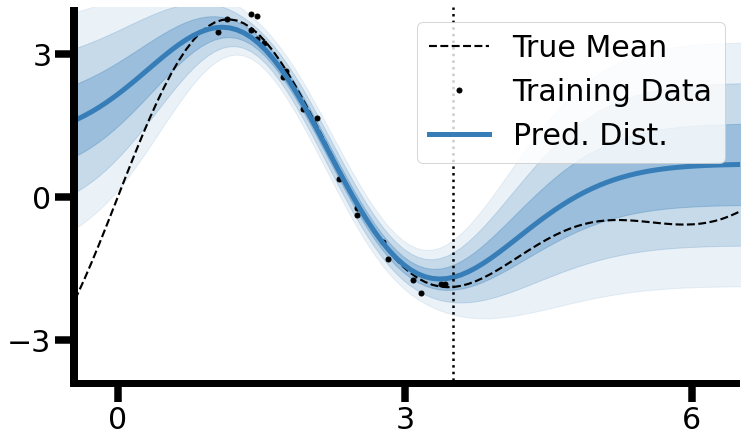

Type **ana_cos_1l**

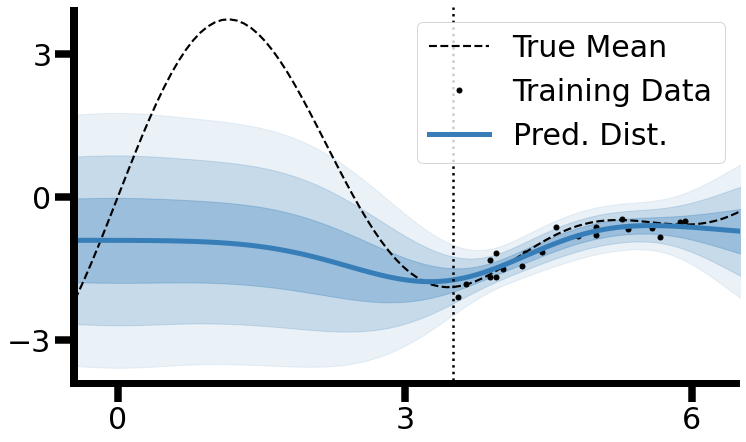

In [7]:
for (X_train_curr, Y_train_curr, data_curr, nngp_props, name) in \
        [(X_all_train, Y_all_train, data_all, nngp_prpps_all, 'all_tasks'),
         (X1_train, Y1_train, data1, nngp_prpps_task1, 'task1'),
         (X2_train, Y2_train, data2, nngp_prpps_task2, 'task2')]:
    for k_props in nngp_props:
        display(Markdown('Type **%s**' % \
                         (k_props['name'])))

        K_train = k_props['K_train']
        K_test = k_props['K_test']
        K_all = k_props['K_all']

        #train_mean, train_var = inference_with_isotropic_gaussian_ll(Y_train_curr, K_train,
        #        torch.diagonal(K_train), K_train, var=likelihood_var)

        try:
            grid_mean, grid_var = inference_with_isotropic_gaussian_ll( \
                Y_train_curr, K_train, K_test, K_all, var=likelihood_var)
        except:
            display(Markdown('**ERROR** **%s** failed.' \
                             % (k_props['name'])))
            continue
            
            
            L, ll_var = cholesky_adaptive_noise(K_train, var=likelihood_var, var_step=1.1)
            display(Markdown('**WARN** Have to use higher ll variance %f for **%s**.' \
                             % (ll_var, k_props['name'])))
            grid_mean, grid_var = inference_with_isotropic_gaussian_ll( \
                Y_train_curr, K_train, K_test, K_all, L_mat=L, var=ll_var)

        grid_std = np.sqrt(grid_var)
            
        plot_predictive_distributions_1dr(data_curr, X_test, pd_samples=None,
            pd_mean=grid_mean, pd_std=grid_std,
            title='GP posterior over functions',
            filename='gp_post_cl_%s' % name, **pd_plot_kwargs)

## Perform rejection sampling

In [8]:
def rejection_sampling(num_samples, pdf_func, max_val, grid_ranges):
    d = len(grid_ranges)
    
    gwidths = torch.ones(d)
    gstarts = torch.zeros(d)
    
    for i, (a, b) in enumerate(grid_ranges):
        gwidths[i] *= b - a
        gstarts[i] += a
    
    samples = []
    while len(samples) < num_samples:
        x = torch.rand(d) * gwidths + gstarts
        u = torch.rand(1)
        
        p_x = pdf_func(x)
        
        if u <= p_x / max_val:
            samples.append(x.detach().cpu().numpy())
        
    return np.vstack(samples)

Type **ana_cos_1l**

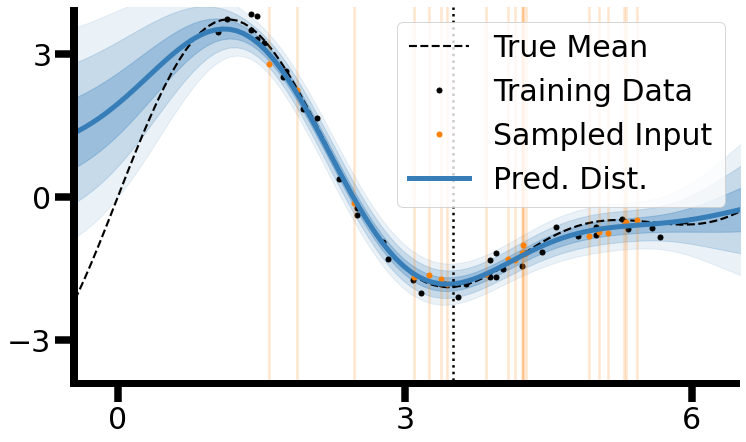

Type **ana_cos_1l**

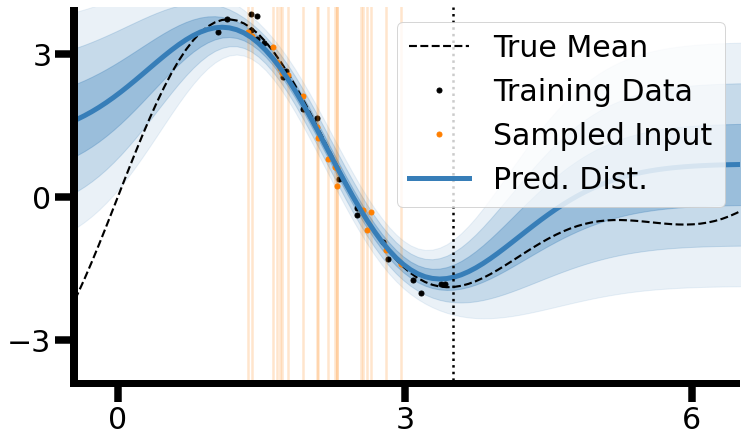

Type **ana_cos_1l**

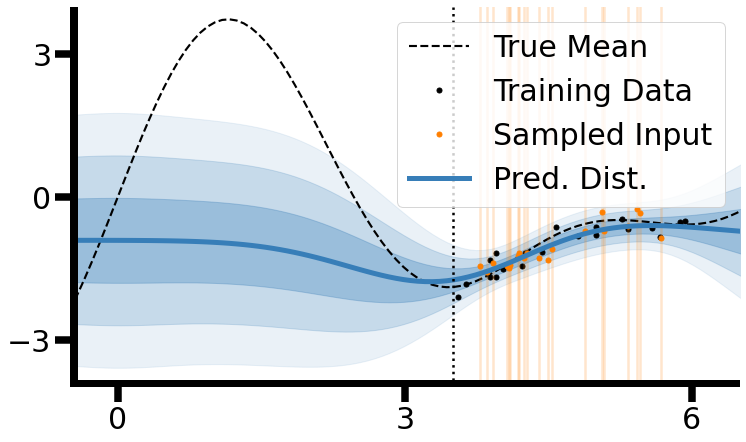

In [9]:
for (X_train_curr, Y_train_curr, data_curr, nngp_props, name) in \
        [(X_all_train, Y_all_train, data_all, nngp_prpps_all, 'all_tasks'),
         (X1_train, Y1_train, data1, nngp_prpps_task1, 'task1'),
         (X2_train, Y2_train, data2, nngp_prpps_task2, 'task2')]:
    for k_props in nngp_props:
        display(Markdown('Type **%s**' % \
                         (k_props['name'])))

        K_train = k_props['K_train']
        K_test = k_props['K_test']
        K_all = k_props['K_all']
        
        #train_mean, train_var = inference_with_isotropic_gaussian_ll(Y_train_curr, K_train,
        #        torch.diagonal(K_train), K_train, var=likelihood_var)

        try:
            grid_mean, grid_var = inference_with_isotropic_gaussian_ll( \
                Y_train_curr, K_train, K_test, K_all, var=likelihood_var)
        except:
            display(Markdown('**ERROR** **%s** failed.' \
                             % (k_props['name'])))
            continue
            
            
            L, ll_var = cholesky_adaptive_noise(K_train, var=likelihood_var, var_step=1.1)
            display(Markdown('**WARN** Have to use higher ll variance %f for **%s**.' \
                             % (ll_var, k_props['name'])))
            grid_mean, grid_var = inference_with_isotropic_gaussian_ll( \
                Y_train_curr, K_train, K_test, K_all, L_mat=L, var=ll_var)

        grid_std = np.sqrt(grid_var)
        
        ### Rejection Sampling ###
        def pot_energy(pos):
            _, K_test, K_all = \
                gen_inference_kernels(X_train_curr, pos.view(1, -1),
                    nutils.determine_mlp_kernel_func(k_props),
                    compute_K_train=False, full_K_test=False)

            _, pos_var = inference_with_isotropic_gaussian_ll( \
                Y_train_curr, K_train, K_test, K_all, var=likelihood_var)

            return pos_var
        
        def pos_to_pdf(pos, temp=1.):    
            return energy_to_pdf(pot_energy(pos), temp=temp)

        def energy_to_pdf(energy, temp=1.):    
            return torch.exp(-energy / temp)

        T = .01

        grid_post_pdf = energy_to_pdf(grid_var, temp=T)

        ar_samples = rejection_sampling(20, lambda e: pos_to_pdf(e, temp=T), grid_post_pdf.max() + 1e-5, [[-1, 7]])
        ### Rejection Sampling -- Done ###
        
        ### Sample outputs ###
        def sample_y(pos):
            _, K_test, K_all = \
                gen_inference_kernels(X_train_curr, pos,
                    nutils.determine_mlp_kernel_func(k_props),
                    compute_K_train=False, full_K_test=False)

            pos_mean, pos_var = inference_with_isotropic_gaussian_ll( \
                Y_train_curr, K_train, K_test, K_all, var=likelihood_var)

            pos_std = torch.sqrt(pos_var)
            
            return torch.normal(pos_mean, pos_std)
        
        y_samples = sample_y(torch.from_numpy(ar_samples))
        y_samples = y_samples.numpy()
        
        ### Sample outputs -- Done ###
            
        k_props['post_mean_test'] = grid_mean
        k_props['post_std_test'] = grid_std
        k_props['unc_samples'] = ar_samples
        k_props['unc_samples_y'] = y_samples
            
        plot_predictive_distributions_1dr(data_curr, X_test, pd_samples=None,
            pd_mean=grid_mean, pd_std=grid_std, samples_in=ar_samples,
            samples_out=y_samples,
            title='GP posterior over functions',
            filename='gp_post_cl_fake_and_real_%s' % name, **pd_plot_kwargs)

## Perform Continual Learning

Type **ana_cos_1l**

Investiagting **ana_cos_1l**

  0%|          | 0/100 [00:00<?, ?it/s]

Kernel computation took 0.021917 seconds.

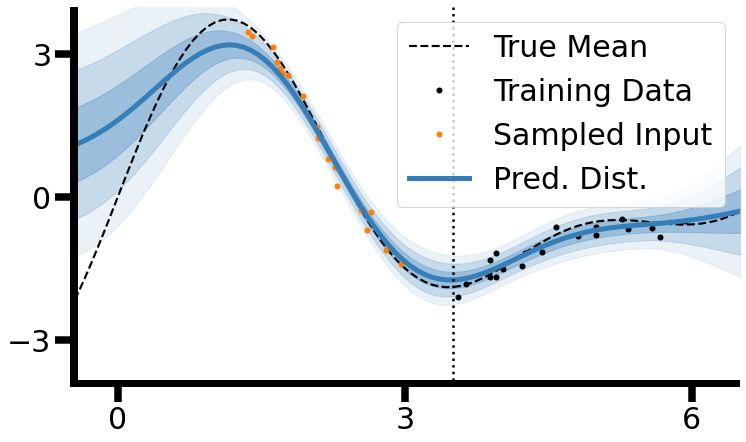

In [12]:
for i, k_props in enumerate(nngp_prpps_task2):
    display(Markdown('Type **%s**' % \
                     (k_props['name'])))
    
    k_props_other = nngp_prpps_task1[i]
    
    if 'unc_samples' not in k_props_other.keys():
        display(Markdown('**ERROR** **%s** failed.' \
                         % (k_props_other['name'])))
        continue
    
    unc_samples = k_props_other['unc_samples']
    unc_samples_y = k_props_other['unc_samples_y']

    X_tmp = torch.cat([torch.from_numpy(unc_samples), X2_train], dim=0)
    Y_tmp = torch.cat([torch.from_numpy(unc_samples_y).view(-1, 1),
                       Y2_train], dim=0)

    k_props_tmp = [dict(k_props)]
    nutils.compute_kernel_values(k_props_tmp, X_test, X_tmp, Y_tmp,
                             nutils.determine_mlp_kernel_func, test_bs=50,
                             out_dir=None, try_inference=False,
                             heatmap_kwargs=None)
    k_props_tmp = k_props_tmp[0]
    
    K_train = k_props_tmp['K_train']
    K_test = k_props_tmp['K_test']
    K_all = k_props_tmp['K_all']

    try:
        grid_mean, grid_var = inference_with_isotropic_gaussian_ll( \
            Y_tmp, K_train, K_test, K_all, var=likelihood_var)
    except:
        display(Markdown('**ERROR** **%s** failed.' \
                         % (k_props['name'])))
        continue


        L, ll_var = cholesky_adaptive_noise(K_train, var=likelihood_var, var_step=1.1)
        display(Markdown('**WARN** Have to use higher ll variance %f for **%s**.' \
                         % (ll_var, k_props['name'])))
        grid_mean, grid_var = inference_with_isotropic_gaussian_ll( \
            Y_tmp, K_train, K_test, K_all, L_mat=L, var=ll_var)

    grid_std = np.sqrt(grid_var)
    
    plot_predictive_distributions_1dr(data2, X_test, pd_samples=None,
        pd_mean=grid_mean, pd_std=grid_std, samples_in=unc_samples,
        samples_out=unc_samples_y,
        title='GP posterior over functions',
        filename='gp_post_cl_fake1_real2', **pd_plot_kwargs)